In [ ]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor
!pip install pillow
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 2s (2,038 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [ ]:
!sudo apt-get install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (1:4.00~git30-7274cfa-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
kor
osd


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

colab_path = "/gdrive/My Drive/Capston/frozen_east_text_detection.pb"  # 경로예시: 구글드라이브/내 드라이브/Colab Notebooks/과제폴더명

 # %cd drive/MyDrive/Colab Notebooks/Tesseract_OCR
#%cd drive/MyDrive/Capston/frozen_east_text_detection.pb

Mounted at /gdrive


[INFO] loading EAST text detector...


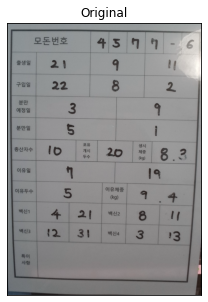

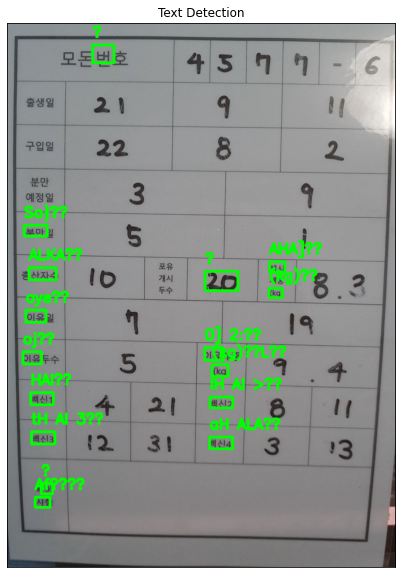

In [ ]:
from imutils.object_detection import non_max_suppression
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import imutils
import numpy as np
import requests
import pytesseract
import cv2


def plt_imshow(title='image', img=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)


#Load Model
layerNames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

# 사전에 훈련된 EAST text detector 모델 Load
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(colab_path)

width = 640
height = 640
min_confidence = 0.5
padding = 0.0

#Load Image


#path = '/content/sample_data/IMG_5937.HEIC'
path = '/content/sample_data/mb_table.jpeg'
org_image = cv2.imread(path)


rgb_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)

# url = 'https://user-images.githubusercontent.com/69428232/149087561-4803b3e0-bcb4-4f9f-a597-c362db24ff9c.jpg'

# /content/mb_table.jpeg

# image_nparray = np.asarray(bytearray(rgb_image.content), dtype=np.uint8)
# org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

rgb_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)

plt_imshow("Original", rgb_image)


#Image Resize
orig = rgb_image.copy()
(origH, origW) = rgb_image.shape[:2]

(newW, newH) = (width, height)
rW = origW / float(newW)
rH = origH / float(newH)

rgb_image = cv2.resize(rgb_image, (newW, newH))
(H, W) = rgb_image.shape[:2]

#Text Detection
blob = cv2.dnn.blobFromImage(rgb_image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

#Recognition
results = []

for (startX, startY, endX, endY) in boxes:
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    dX = int((endX - startX) * padding)
    dY = int((endY - startY) * padding)

    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
    # 영역 추출
    roi = orig[startY:endY, startX:endX]

    config = ("-l eng --psm 4")

    # 여기기 부분을을 deeptextrecognitonbenchmark로로 바꿔야야 할듯듯
    text = pytesseract.image_to_string(roi, config=config)

    results.append(((startX, startY, endX, endY), text))

    #result
results = sorted(results, key=lambda r: r[0][1])

output = orig.copy()

# 결과 출력
for ((startX, startY, endX, endY), text) in results:
    cv2.rectangle(output, (startX, startY), (endX, endY), (0, 255, 0), 5)
    cv2.putText(output, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 5)

plt_imshow("Text Detection", output, figsize=(16, 10))